<a href="https://colab.research.google.com/github/mario-rot/ComputerVisionCourse-MAI/blob/main/Session%2011/P11_Mario_Lauren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory #5_2 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%shell
git clone https://github.com/mario-rot/ComputerVisionCourse-MAI.git
cd 'ComputerVisionCourse-MAI'
mv 'Session 11/TrayDataset' /content/
mv 'customplots.py' /content/
mv 'utils.py' /content/

Cloning into 'ComputerVisionCourse-MAI'...
remote: Enumerating objects: 14871, done.
remote: Counting objects: 100% (3292/3292), done.
remote: Compressing objects: 100% (3037/3037), done.
remote: Total 14871 (delta 239), reused 3270 (delta 226), pack-reused 11579
Receiving objects: 100% (14871/14871), 168.44 MiB | 30.31 MiB/s, done.
Resolving deltas: 100% (242/242), done.
Checking out files: 100% (14430/14430), done.


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

from tensorflow import keras
from tensorflow.keras.utils import load_img
from PIL.ImageOps import autocontrast
from customplots import custom_grids

from skimage.io import imread
from skimage.transform import resize
from skimage.util import img_as_int
from sklearn.metrics import jaccard_score

# Constants

*   Change the path of the directories according to your drive location.

In [ ]:
root_path = r'/content/TrayDataset/'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

*   Define the constants needed for training the model

In [ ]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [8]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

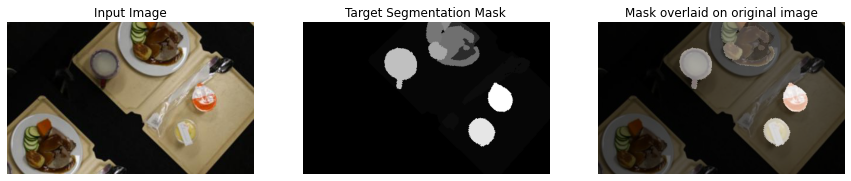

In [9]:
# solution

f, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(load_img(train_img_paths[9]))
axes[0].set_title('Input Image')
axes[0].axis('off')

# Display auto-contrast version of corresponding target (per-pixel categories)
axes[1].imshow(autocontrast(load_img(train_mask_paths[9])))
axes[1].set_title('Target Segmentation Mask')
axes[1].axis('off')

# Overlaid images
axes[2].imshow(load_img(train_img_paths[9]))
axes[2].imshow(autocontrast(load_img(train_mask_paths[9])), alpha=0.6)
axes[2].set_title('Mask overlaid on original image')
axes[2].axis('off')


plt.show()

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [10]:
# solution

class ImageGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] -= 1
        return x, y


# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [11]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model
    

In [12]:
# Free up RAM in case the model definition cells were run multiple times

import keras
keras.backend.clear_session()

In [13]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [14]:
# solution

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [15]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)

val_gen = ImageGenerator(8, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [16]:
# solution

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

*   Instantiate a ModelCheckpoint callback to save only the best model

In [17]:
# solution

callbacks = [
    keras.callbacks.ModelCheckpoint("tray_segmentation.h5", save_best_only=True)
]

*   Train the model using fit method

In [18]:
# solution
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 25s 270ms/step - loss: 1.7112 - val_loss: 2.6164
Epoch 2/25
38/38 [==============================] - 9s 236ms/step - loss: 0.6443 - val_loss: 6.6617
Epoch 3/25
38/38 [==============================] - 9s 245ms/step - loss: 0.4730 - val_loss: 6.6493
Epoch 4/25
38/38 [==============================] - 9s 241ms/step - loss: 0.3198 - val_loss: 3.6133
Epoch 5/25
38/38 [==============================] - 10s 251ms/step - loss: 0.2819 - val_loss: 7.5581
Epoch 6/25
38/38 [==============================] - 9s 245ms/step - loss: 0.2213 - val_loss: 4.8499
Epoch 7/25
38/38 [==============================] - 10s 248ms/step - loss: 0.1946 - val_loss: 7.0484
Epoch 8/25
38/38 [==============================] - 10s 249ms/step - loss: 0.1753 - val_loss: 6.9643
Epoch 9/25
38/38 [==============================] - 9s 245ms/step - loss: 0.1583 - val_loss: 4.9596
Epoch 10/25
38/38 [==============================] - 9s 244ms/step - loss: 0.1531 - val_loss: 6.

# Visualize predictions

*   Generate predictions for all images in the validation set

In [19]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [20]:
# solution

val_preds = model.predict(val_gen)

8/8 [==============================] - 1s 8ms/step


*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [37]:
# solution
masks = []
for i in range(len(val_preds)):
  masks.append(np.argmax(val_preds[i], axis=-1))
  print('Mask', str(i) + ':')
  print(masks[i], '\n')

Mask 0:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Mask 1:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Mask 2:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Mask 3:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Mask 4:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Mask 5:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Mask 6:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Mask 7:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 

*   Read the test mask images to create the ground truth

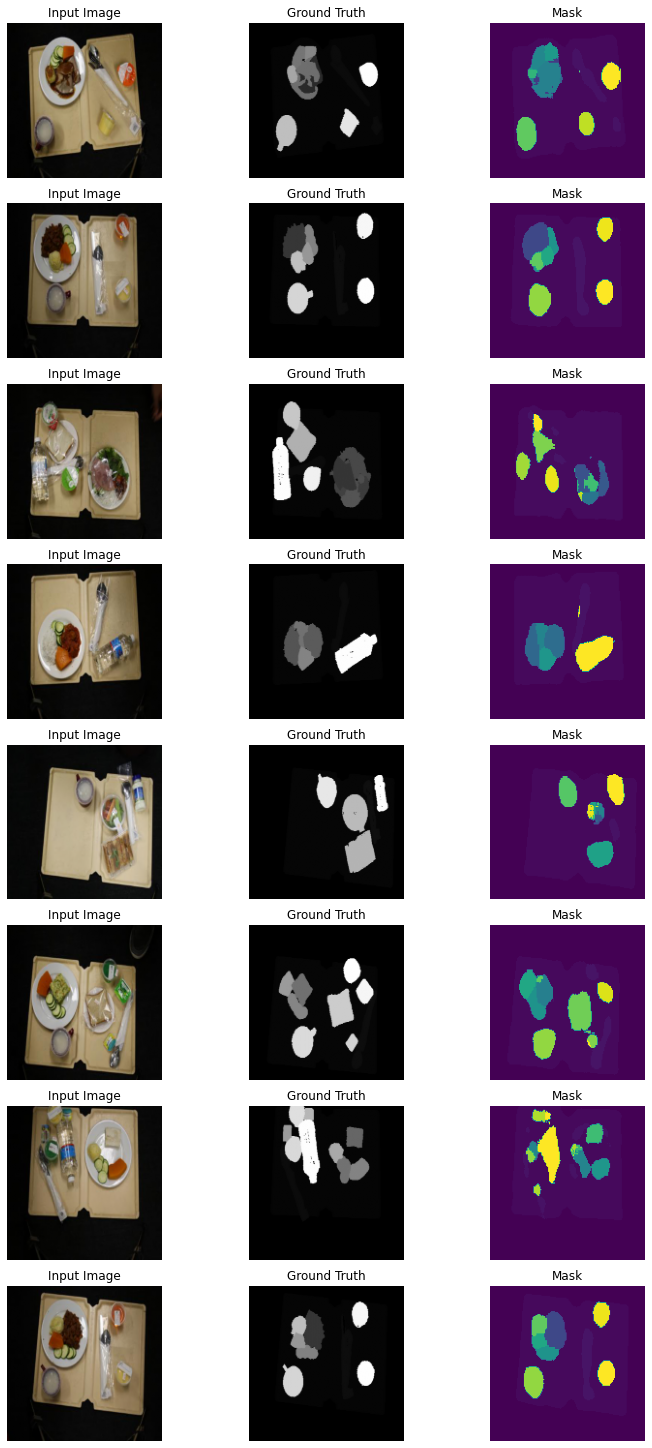

In [50]:
# solution 

imgs = []
titles = []
for i in range(len(masks)):
  input_img = imread(test_img_paths[i])
  input_img = resize(input_img, (160, 160))
  imgs.append(input_img)
  titles.append('Input Image')

  ground_truth = autocontrast(load_img(test_mask_paths[i]))
  ground_truth = resize(np.array(ground_truth), (160, 160))
  imgs.append(ground_truth)
  titles.append('Ground Truth')

  imgs.append(masks[i])
  titles.append('Mask')

custom_grids(imgs, 8, 3, titles=titles, axis='off', figsize=(10, 20)).show()

*   For each validation image, find the jaccard similarity score

In [55]:
# solution

for i in range(len(masks)):
  g_t = img_as_int(resize(imread(test_mask_paths[i], as_gray=True), img_size))

  print('Image', str(i))
  print(jaccard_score(g_t.flatten(), masks[i].flatten(), average='micro'), '\n')

Image 0
0.3264592346951994 

Image 1
0.333645906592691 

Image 2
0.3444672023528176 

Image 3
0.3394025009156072 

Image 4
0.34189490237190406 

Image 5
0.3442201160440022 

Image 6
0.335559265442404 

Image 7
0.33336805645980366 



*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter? 
*   Which parameter is used for what type of problem?

**Solution**

* *The 'average' parameter of the Jaccard similarity score function determines the type of averaging that is used on the date when performing the Jaccard similarity.*

* *The 'average' parameter can have the following values: binary, micro, macro, weighted, samples, or None.*

* *The 'binary' parameter is used when the target outputs are binary, whereas the 'samples' parameter is used for multilabel classification. The 'micro' parameter is used to globally calculate the metrics by taking into account all true positives, false negatives, and false positives. The 'macro' parameter is used to calculate the metrics for each label, regardless of any imbalances there might be among the labels. If the user desires the metrics to take these imbalances into account, the 'weighted' parameter weights the metrics to do so.*

...

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

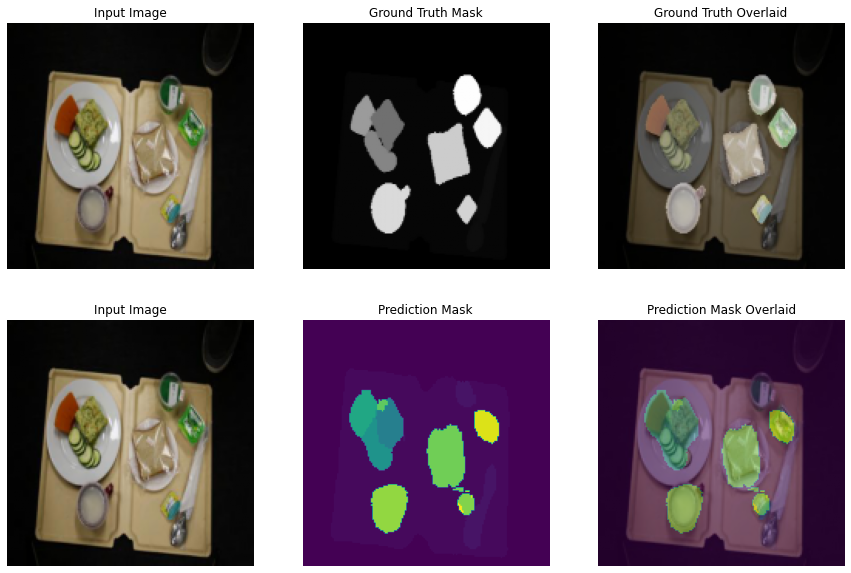

In [61]:
from keras.engine.compile_utils import map_missing_dict_keys

i = random.randint(0,9)

f, axes = plt.subplots(2, 3, figsize=(15, 10))

input_img = imread(test_img_paths[i])
input_img = resize(input_img, (160, 160))
axes[0][0].imshow(input_img)
axes[0][0].set_title('Input Image')
axes[0][0].axis('off')

ground_truth = autocontrast(load_img(test_mask_paths[i]))
ground_truth = resize(np.array(ground_truth), (160, 160))
axes[0][1].imshow(ground_truth)
axes[0][1].set_title('Ground Truth Mask')
axes[0][1].axis('off')

axes[0][2].imshow(input_img)
axes[0][2].imshow(ground_truth, alpha=0.5)
axes[0][2].set_title('Ground Truth Overlaid')
axes[0][2].axis('off')

axes[1][0].imshow(input_img)
axes[1][0].set_title('Input Image')
axes[1][0].axis('off')

prediction_mask = masks[i]
prediction_mask = resize(prediction_mask, (160, 160))
axes[1][1].imshow(prediction_mask)
axes[1][1].set_title('Prediction Mask')
axes[1][1].axis('off')

axes[1][2].imshow(input_img)
axes[1][2].imshow(prediction_mask, alpha=0.5)
axes[1][2].set_title('Prediction Mask Overlaid')
axes[1][2].axis('off')

plt.show()

*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

*(Double-click or enter to edit)*

...

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [ ]:
# solution



*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

*(Double-click or enter to edit)*

...

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

*(Double-click or enter to edit)*

...

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**

*The goal of image segmentation is to identify and classify whole objects. On the other hand, semantic segmentation aims to assign each pixel to an object classification. In other words, it is performing image classification pixel by pixel.*

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

*An encoder generates a high-dimensional feature vector from an input image, while a decoder uses a high-dimensional vector to generate a mask. The encoder and decoder often work together in an encoder-decoder network.*

...

*   What is upsampling?

**Solution**

*(Double-click or enter to edit)*

...

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

*(Double-click or enter to edit)*

...

*   What are some applications of U-Net?

**Solution**

*(Double-click or enter to edit)*

...

*   What are the other popular semantic segmentation algorithms?
*   How are they different from each other?

**Solution**

*(Double-click or enter to edit)*

...

*   What are the popular semantic segmentation datasets which are available for public access?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P5_2: Image Segmentation using UNet**
Deadline for P5_2 submission in CampusVirtual is: **Thursday, the 22nd of December, 2022**